In [1]:
!pip3 install tensorflow-estimator==2.6.0

In [2]:
pip install Pillow==9.5.0

In [3]:
# Tensorflow와 Tensoflow Hub에 있는 이미 학습된 모델을 활용하기 위한 모듈
import tensorflow as tf
import tensorflow_hub as hub

# 이미지를 다운로드하는 데에 사용하는 모듈
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# 이미지에 선과 폰트를 넣기 위한 모듈
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Detection하는 데에 소요된 시간을 점검하기 위한 모듈
import time

In [4]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [5]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):

  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)  # 이미지 읽기
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS) # 이미지 조정
  pil_image_rgb = pil_image.convert("RGB") #RBG로 변환
  pil_image_rgb.save(filename, format="JPEG", quality=90) # 이미지 저장
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [6]:
def draw_bounding_box_on_image(image,
                               ymin, xmin, ymax, xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):

  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)

# BBox 테두리 그리기
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]

  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

In [7]:
# BBox 그리기
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

# BBox 그리기 적용
  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])  # 박스 좌표값
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image


Resizing to 1280x856
Original size: 640x360
New size: 640x360

Resizing to 800x600
Original size: 640x360
New size: 640x360

Resizing to 224x224
Original size: 640x360
New size: 224x126


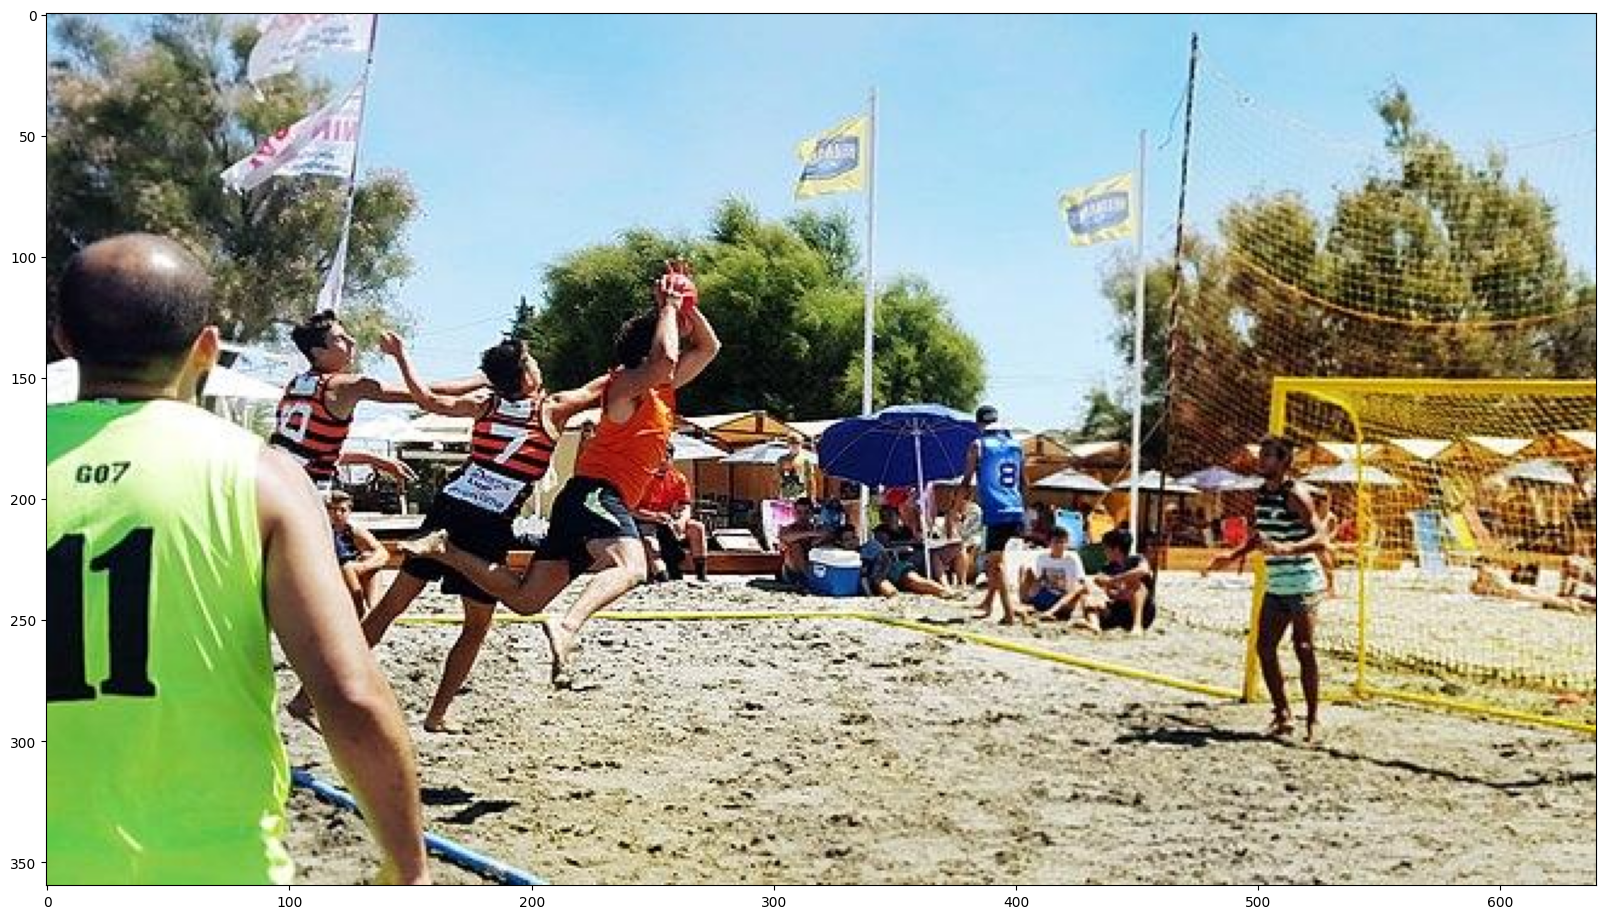

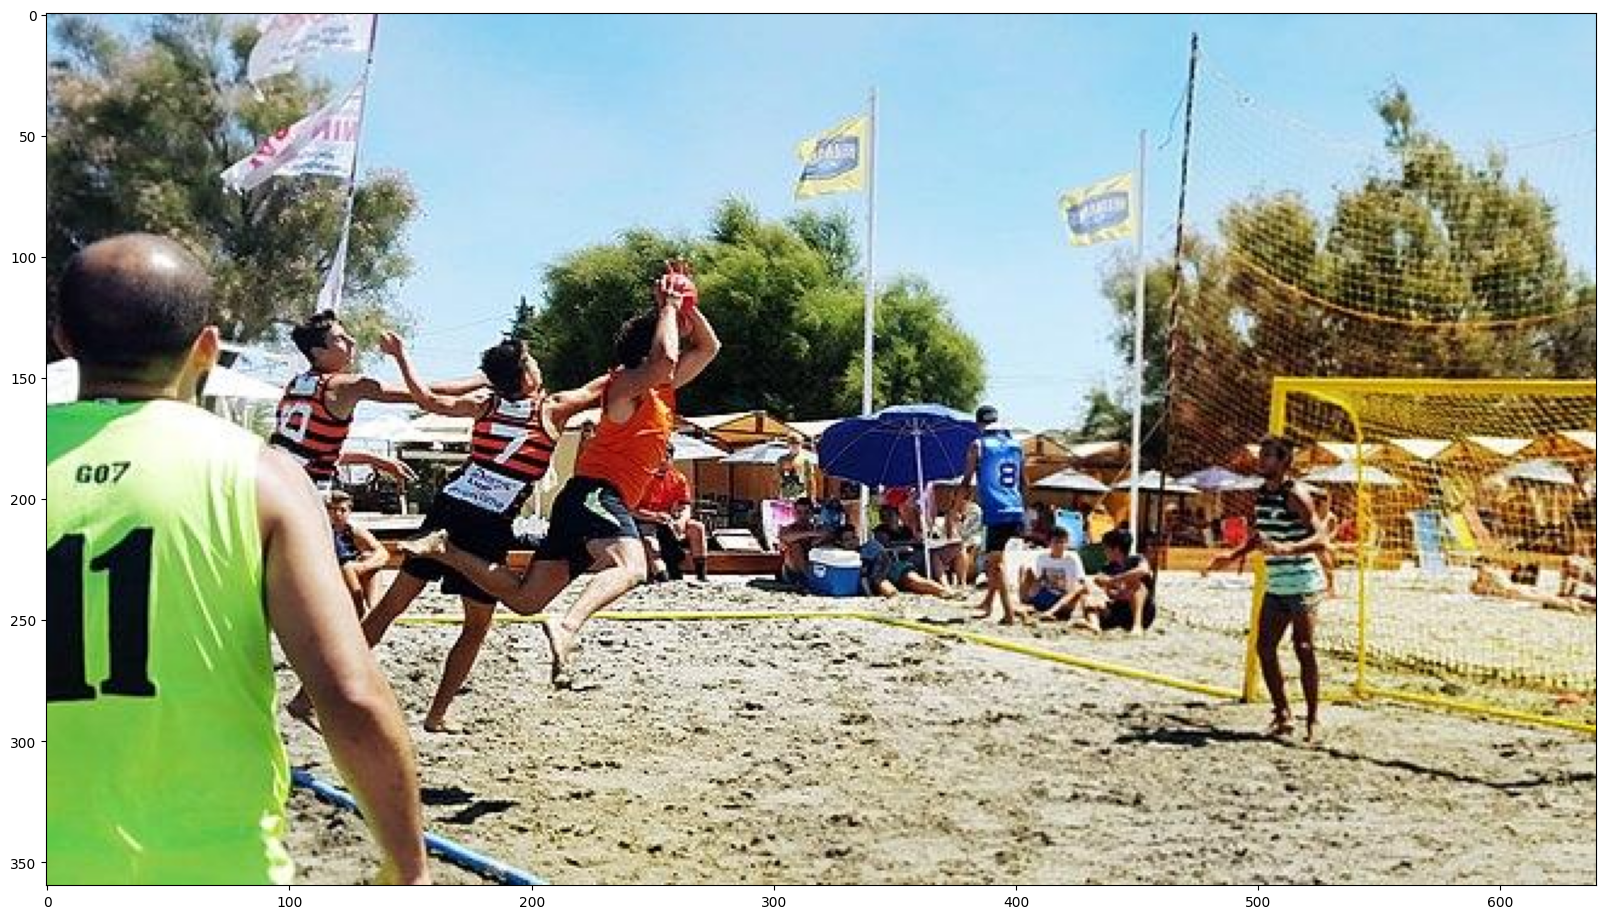

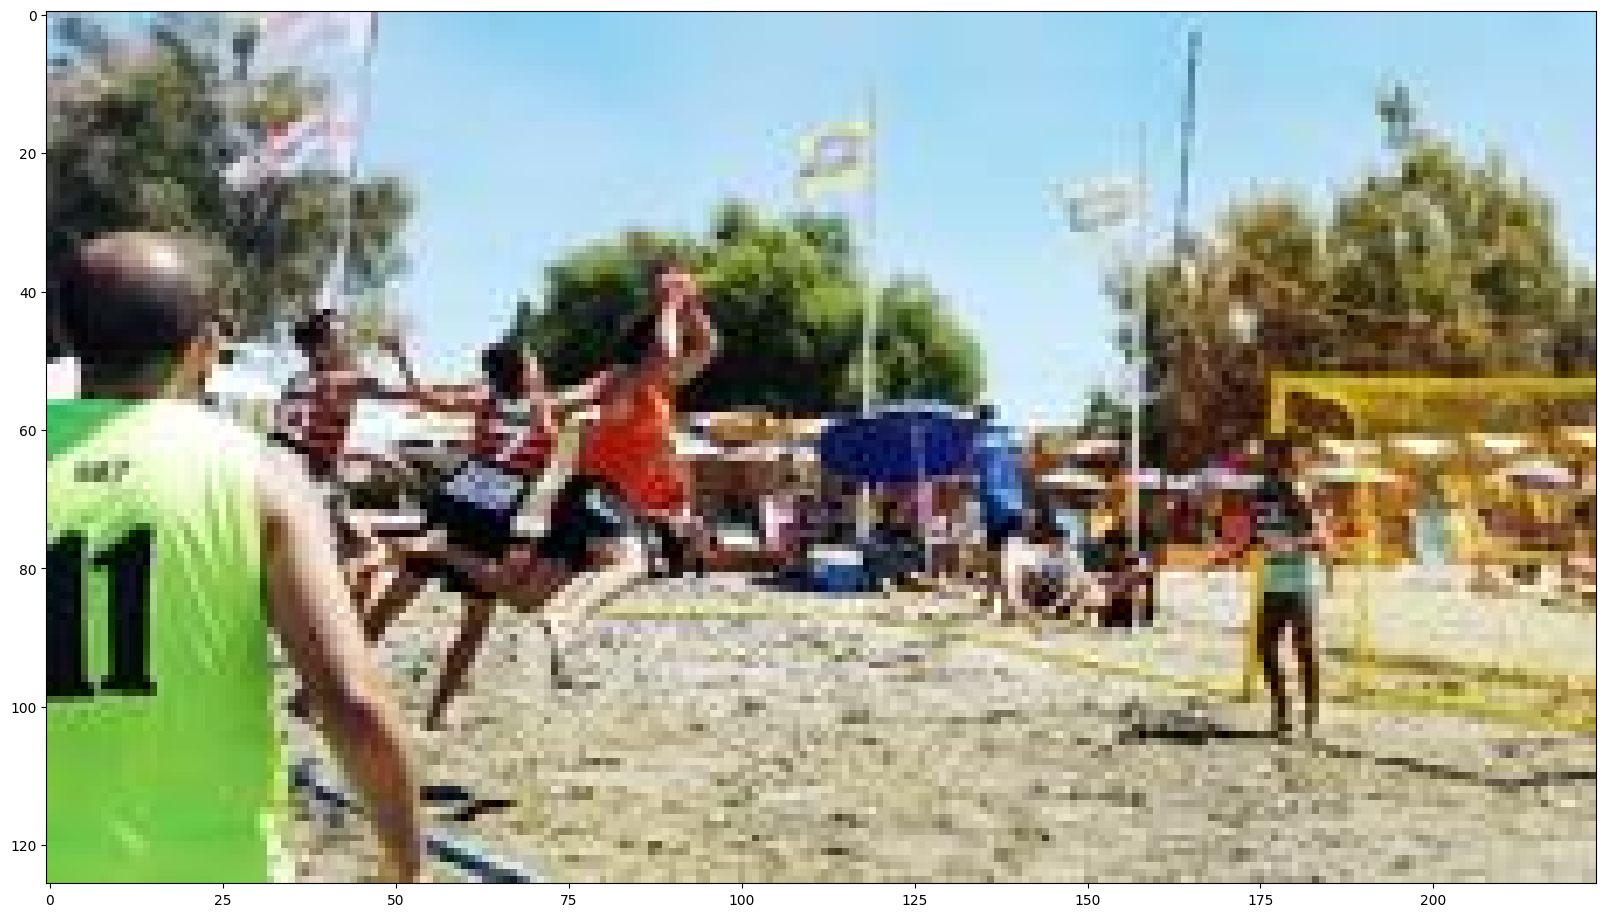

In [8]:
def download_and_resize_image(url, new_width, new_height, preserve_aspect_ratio=True):
    # Download image
    response = tf.keras.utils.get_file('image', origin=url)
    img = Image.open(response)

    # Original size
    original_width, original_height = img.size
    print(f"Original size: {original_width}x{original_height}")

    # Resize image
    if preserve_aspect_ratio:
        img.thumbnail((new_width, new_height))
    else:
        img = img.resize((new_width, new_height))

    # New size
    print(f"New size: {img.size[0]}x{img.size[1]}")

    # Save and return path
    output_path = 'downloaded_image.jpg'
    img.save(output_path)
    return output_path

# Try different sizes
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/db/Torneo_beach_handball.jpg/640px-Torneo_beach_handball.jpg"

# Test different dimensions
sizes = [
    (1280, 856),  # Original aspect ratio
    (800, 600),   # Standard size
    (224, 224)    # VGG16 input size
]

for width, height in sizes:
    print(f"\nResizing to {width}x{height}")
    downloaded_image_path = download_and_resize_image(image_url, width, height, True)
    display_image(np.array(Image.open(downloaded_image_path)))

In [9]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default'] # detector에 사용할 모듈 저장

In [10]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [11]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

# 소요시간 측정
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

# 이미지 추론 개수와 추론 시간 출력
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

# 이미지 내 박스로 entity, scores를 추가하여 출력
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Found 100 objects.
Inference time:  93.87363076210022


<ipython-input-6-8b156eaed91c>:19: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-6-8b156eaed91c>:29: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


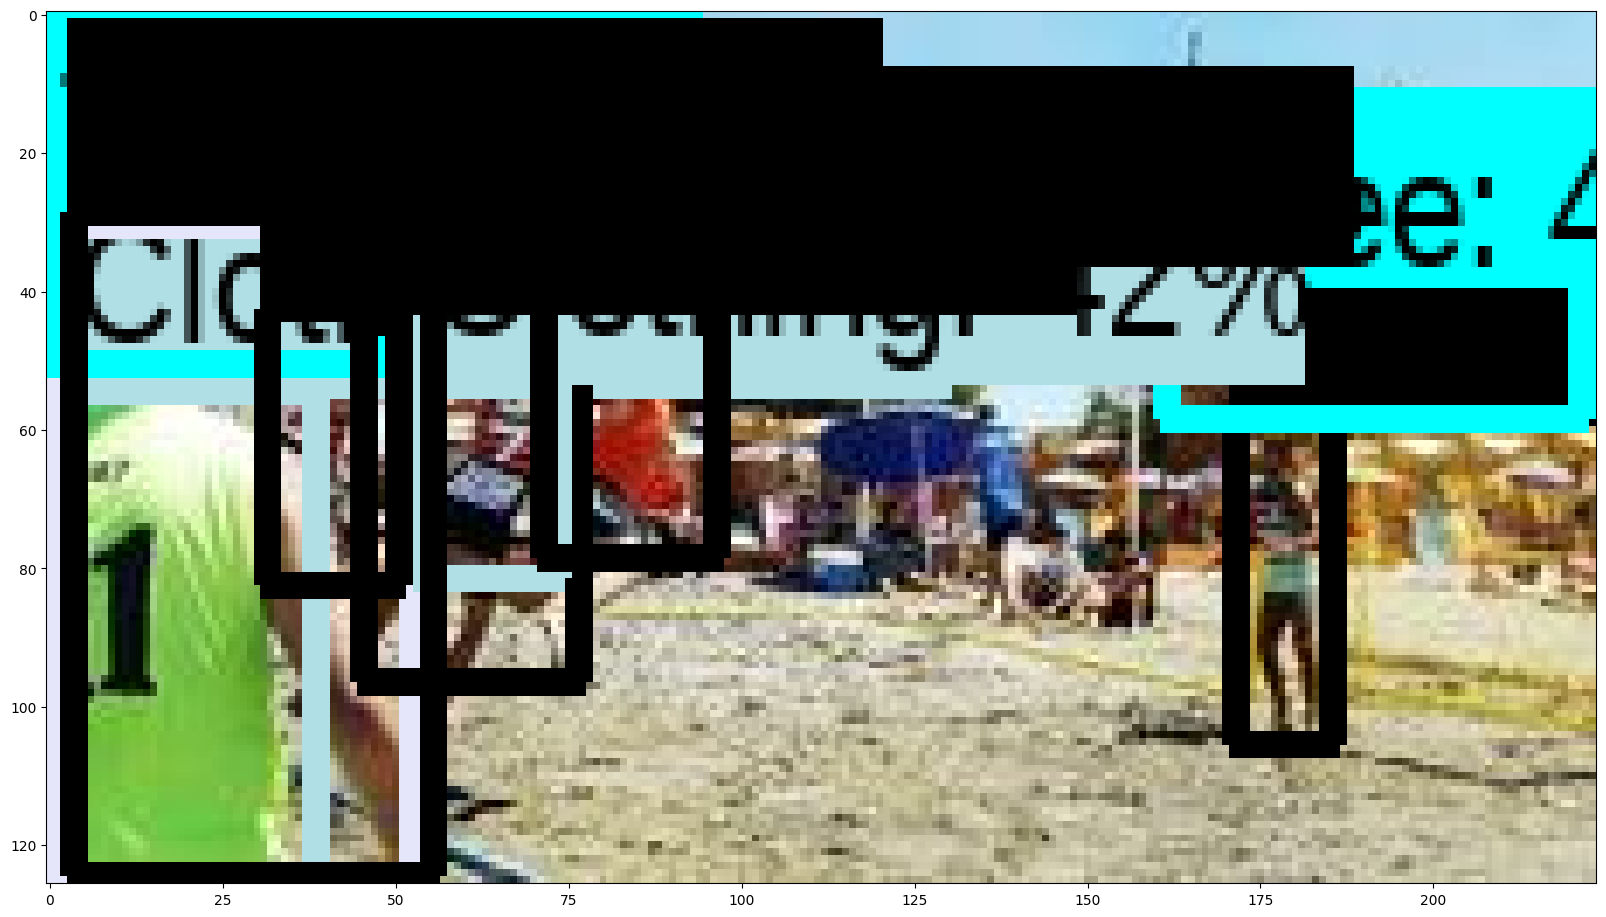

In [12]:
run_detector(detector, downloaded_image_path)

In [13]:
# 이미지 불러오기
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import time

def test_custom_image(model, image_path):
    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    processed_img = img_array / 255.0
    processed_img = np.expand_dims(processed_img, axis=0)

    # Measure inference time
    start_time = time.time()
    prediction = model.predict(processed_img)
    end_time = time.time()

    # Display results
    plt.figure(figsize=(8, 8))
    plt.imshow(img)

    # Get prediction result
    class_name = "Class 1" if prediction[0][0] > 0.5 else "Class 0"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]

    plt.title(f"Prediction: {class_name}\nConfidence: {confidence:.2%}\nInference Time: {end_time-start_time:.3f}s")
    plt.axis('off')
    plt.show()

# Example usage:
# test_custom_image(model, "path/to/your/image.jpg")

In [14]:
# 테스트
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import time

def test_vgg16_model(model, image_path):
    # Load and preprocess test image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    processed_img = img_array / 255.0
    processed_img = np.expand_dims(processed_img, axis=0)

    # Run inference and measure time
    start_time = time.time()
    prediction = model.predict(processed_img, verbose=0)
    inference_time = time.time() - start_time

    # Display results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Input Image')

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.6, f'Prediction: {"Class 1" if prediction[0][0] > 0.5 else "Class 0"}',
             horizontalalignment='center')
    plt.text(0.5, 0.4, f'Confidence: {max(prediction[0][0], 1-prediction[0][0]):.2%}',
             horizontalalignment='center')
    plt.text(0.5, 0.2, f'Inference Time: {inference_time:.3f}s',
             horizontalalignment='center')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# test_vgg16_model(model, 'path/to/test/image.jpg')

In [15]:
# 문제 2-2. 모델 불러오기
import tensorflow as tf
import tensorflow_hub as hub

# Define available models with their handles
models = {
    'EfficientDet D4': 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
    'SSD MobileNet V2': 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
    'Faster RCNN + InceptionResNet V2': 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2/1'
}

def load_detection_model(model_name):
    print(f"Loading {model_name}...")
    model_handle = models[model_name]
    detector = hub.load(model_handle).signatures['default']
    print("Model loaded successfully!")
    return detector

# Load models for comparison
# Example usage:
# detector1 = load_detection_model('EfficientDet D4')
# detector2 = load_detection_model('SSD MobileNet V2')
# detector3 = load_detection_model('Faster RCNN + InceptionResNet V2')


In [16]:
# 문제 2-2. 테스트
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import time
import matplotlib.pyplot as plt

def test_detection_models(image_path, detectors):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    results = {}

    # Test each model
    for model_name, detector in detectors.items():
        print(f"\nTesting {model_name}...")

        # Run inference with timing
        start_time = time.time()
        result = detector(converted_img)
        inference_time = time.time() - start_time

        # Process results
        result_dict = {key: value.numpy() for key, value in result.items()}

        # Store results
        results[model_name] = {
            'time': inference_time,
            'boxes': result_dict['detection_boxes'],
            'scores': result_dict['detection_scores'],
            'classes': result_dict['detection_class_entities']
        }

        # Print results
        print(f"Inference time: {inference_time:.3f} seconds")
        print("Top 5 detections:")
        for i in range(min(5, len(result_dict['detection_scores']))):
            print(f"{result_dict['detection_class_entities'][i].decode('utf-8')}: "
                  f"{result_dict['detection_scores'][i]:.2%}")

    return results

# Example usage:
"""
detectors = {
    'EfficientDet': detector1,
    'SSD MobileNet': detector2,
    'Faster RCNN': detector3
}

results = test_detection_models('path/to/test/image.jpg', detectors)
"""

"\ndetectors = {\n    'EfficientDet': detector1,\n    'SSD MobileNet': detector2,\n    'Faster RCNN': detector3\n}\n\nresults = test_detection_models('path/to/test/image.jpg', detectors)\n"

In [17]:
# 문제 2-2. 테스트
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import time
import matplotlib.pyplot as plt

def test_detection_models(image_path, detectors):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    results = {}

    # Test each model
    for model_name, detector in detectors.items():
        print(f"\nTesting {model_name}...")

        # Run inference with timing
        start_time = time.time()
        result = detector(converted_img)
        inference_time = time.time() - start_time

        # Process results
        result_dict = {key: value.numpy() for key, value in result.items()}

        # Store results
        results[model_name] = {
            'time': inference_time,
            'boxes': result_dict['detection_boxes'],
            'scores': result_dict['detection_scores'],
            'classes': result_dict['detection_class_entities']
        }

        # Print results
        print(f"Inference time: {inference_time:.3f} seconds")
        print("Top 5 detections:")
        for i in range(min(5, len(result_dict['detection_scores']))):
            print(f"{result_dict['detection_class_entities'][i].decode('utf-8')}: "
                  f"{result_dict['detection_scores'][i]:.2%}")

    return results

# Example usage:
"""
detectors = {
    'EfficientDet': detector1,
    'SSD MobileNet': detector2,
    'Faster RCNN': detector3
}

results = test_detection_models('path/to/test/image.jpg', detectors)
"""

"\ndetectors = {\n    'EfficientDet': detector1,\n    'SSD MobileNet': detector2,\n    'Faster RCNN': detector3\n}\n\nresults = test_detection_models('path/to/test/image.jpg', detectors)\n"

In [18]:
# 문제 2-2. 결과 비교
print("1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.")
print("2번째 모델인 ...")

1번째 모델인 Inception ResNet을 사용한 Faster RCNN은 조금 느리지만 높은 정확성을 보였습니다.
2번째 모델인 ...
